In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm


In [2]:
class TUMDataset(Dataset):
    def __init__(self, rgb_file, depth_file, gt_file, transform=None, depth_transform=None, base_dir=""):
        rgb_file = os.path.join(base_dir,rgb_file)
        depth_file = os.path.join(base_dir,depth_file)
        gt_file = os.path.join(base_dir,gt_file)
        self.rgb_data = self._read_file(rgb_file)
        self.depth_data = self._read_file(depth_file)
        self.gt_data = self._read_file(gt_file)

        n = min(len(self.rgb_data), len(self.depth_data), len(self.gt_data))
        self.rgb_data = self.rgb_data[:n]
        self.depth_data = self.depth_data[:n]
        self.gt_data = self.gt_data[:n]

        self.transform = transform
        self.depth_transform = depth_transform
        self.base_dir = base_dir

    def _read_file(self, filename):
        with open(filename, 'r') as f:
            lines = [line.strip() for line in f if line.strip() and not line.startswith("#")]
        data = []
        for line in lines:
            parts = line.replace(",", " ").replace("\t", " ").split()
            timestamp = float(parts[0])
            data.append((timestamp, parts[1:]))
        return data

    def __len__(self):
        return len(self.rgb_data)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.base_dir, self.rgb_data[idx][1][0])
        depth_path = os.path.join(self.base_dir, self.depth_data[idx][1][0])
        pose_vals = list(map(float, self.gt_data[idx][1]))

        rgb = Image.open(rgb_path).convert("RGB")
        depth = Image.open(depth_path)

        if self.transform:
            rgb = self.transform(rgb)
        if self.depth_transform:
            depth = self.depth_transform(depth)

        pose = torch.tensor(pose_vals, dtype=torch.float32)

        return {
            "rgb": rgb,
            "depth": depth,
            "pose": pose
        }


In [3]:
class PoseNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PoseNet, self).__init__()
        resnet = models.resnet18(pretrained=pretrained)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # drop final FC
        self.fc = nn.Linear(512, 7)  # tx, ty, tz, qx, qy, qz, qw

    def forward(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        out = self.fc(x)
        
        # Split into translation and quaternion
        trans = out[:, :3]
        rot = out[:, 3:]
        
        # Normalize rotation **without in-place modification**
        rot = F.normalize(rot, dim=-1)
        
        # Concatenate and return
        return torch.cat([trans, rot], dim=1)




In [4]:
# Resize to ResNet input
rgb_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

depth_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Adjust this path to your dataset
dataset = TUMDataset(
    rgb_file="rgb.txt",
    depth_file="depth.txt",
    gt_file="groundtruth.txt",
    transform=rgb_transform,
    depth_transform=depth_transform,
    base_dir="rgbd_dataset_freiburg3_long_office_household"  # assumes images/rgb and images/depth are in paths in txt files
)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [5]:
from torch.utils.data import random_split

# Set the split ratio (e.g., 80% train, 20% test)
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Create the splits
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [6]:
def pose_loss(pred, target, beta=250.0):
    t_pred = pred[:, :3]
    q_pred = F.normalize(pred[:, 3:], dim=-1)
    t_gt = target[:, :3]
    q_gt = F.normalize(target[:, 3:], dim=-1)
    loss_t = F.mse_loss(t_pred, t_gt)
    loss_q = F.mse_loss(q_pred, q_gt)
    return loss_t + beta * loss_q

model = PoseNet().to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)



d:\Miniconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Miniconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 35

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        rgb = batch["rgb"].to(device)
        pose = batch["pose"].to(device)

        pred = model(rgb)
        loss = pose_loss(pred, pose)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")


100%|██████████| 251/251 [01:21<00:00,  3.07it/s]


Epoch 1/35, Loss: 12.8163


100%|██████████| 251/251 [00:37<00:00,  6.74it/s]


Epoch 2/35, Loss: 2.4564


100%|██████████| 251/251 [00:34<00:00,  7.26it/s]


Epoch 3/35, Loss: 1.5341


100%|██████████| 251/251 [00:34<00:00,  7.26it/s]


Epoch 4/35, Loss: 1.8381


100%|██████████| 251/251 [00:34<00:00,  7.28it/s]


Epoch 5/35, Loss: 2.0233


100%|██████████| 251/251 [00:35<00:00,  7.13it/s]


Epoch 6/35, Loss: 1.5060


100%|██████████| 251/251 [00:36<00:00,  6.95it/s]


Epoch 7/35, Loss: 1.3246


100%|██████████| 251/251 [00:36<00:00,  6.90it/s]


Epoch 8/35, Loss: 2.1286


100%|██████████| 251/251 [00:36<00:00,  6.92it/s]


Epoch 9/35, Loss: 1.3258


100%|██████████| 251/251 [00:36<00:00,  6.90it/s]


Epoch 10/35, Loss: 1.2117


100%|██████████| 251/251 [00:36<00:00,  6.93it/s]


Epoch 11/35, Loss: 1.2444


100%|██████████| 251/251 [00:35<00:00,  6.99it/s]


Epoch 12/35, Loss: 0.8054


100%|██████████| 251/251 [00:35<00:00,  6.97it/s]


Epoch 13/35, Loss: 0.6360


100%|██████████| 251/251 [00:35<00:00,  6.97it/s]


Epoch 14/35, Loss: 0.5876


100%|██████████| 251/251 [00:35<00:00,  6.99it/s]


Epoch 15/35, Loss: 0.7496


100%|██████████| 251/251 [00:35<00:00,  7.01it/s]


Epoch 16/35, Loss: 0.5879


100%|██████████| 251/251 [00:36<00:00,  6.93it/s]


Epoch 17/35, Loss: 0.5828


100%|██████████| 251/251 [00:36<00:00,  6.93it/s]


Epoch 18/35, Loss: 0.5495


100%|██████████| 251/251 [00:36<00:00,  6.97it/s]


Epoch 19/35, Loss: 0.5394


100%|██████████| 251/251 [00:35<00:00,  6.99it/s]


Epoch 20/35, Loss: 0.5610


100%|██████████| 251/251 [00:35<00:00,  6.99it/s]


Epoch 21/35, Loss: 0.5981


100%|██████████| 251/251 [00:35<00:00,  6.99it/s]


Epoch 22/35, Loss: 0.7139


100%|██████████| 251/251 [00:35<00:00,  6.99it/s]


Epoch 23/35, Loss: 0.8274


100%|██████████| 251/251 [00:36<00:00,  6.96it/s]


Epoch 24/35, Loss: 1.0213


100%|██████████| 251/251 [00:36<00:00,  6.97it/s]


Epoch 25/35, Loss: 1.8328


100%|██████████| 251/251 [00:35<00:00,  7.05it/s]


Epoch 26/35, Loss: 1.3230


100%|██████████| 251/251 [00:35<00:00,  7.04it/s]


Epoch 27/35, Loss: 0.8030


100%|██████████| 251/251 [00:35<00:00,  7.04it/s]


Epoch 28/35, Loss: 0.8699


100%|██████████| 251/251 [00:35<00:00,  7.03it/s]


Epoch 29/35, Loss: 0.6987


100%|██████████| 251/251 [00:35<00:00,  7.01it/s]


Epoch 30/35, Loss: 0.5596


100%|██████████| 251/251 [00:36<00:00,  6.93it/s]


Epoch 31/35, Loss: 0.8158


100%|██████████| 251/251 [00:36<00:00,  6.93it/s]


Epoch 32/35, Loss: 0.7084


100%|██████████| 251/251 [00:36<00:00,  6.92it/s]


Epoch 33/35, Loss: 0.7376


100%|██████████| 251/251 [00:35<00:00,  6.98it/s]


Epoch 34/35, Loss: 0.7626


100%|██████████| 251/251 [00:35<00:00,  6.99it/s]

Epoch 35/35, Loss: 0.7303


In [8]:
model.eval()
with torch.no_grad():
    sample = next(iter(test_loader))
    pred = model(sample['rgb'].to(device))
    print("Predicted Pose:", pred[0].cpu().numpy())
    print("Ground Truth Pose:", sample['pose'][0].numpy())


Predicted Pose: [ 1.6314965 -1.1090308  1.5303227  0.716484   0.4649191 -0.2714349
 -0.4436486]
Ground Truth Pose: [ 1.629  -1.0888  1.564   0.7164  0.4633 -0.2804 -0.4398]


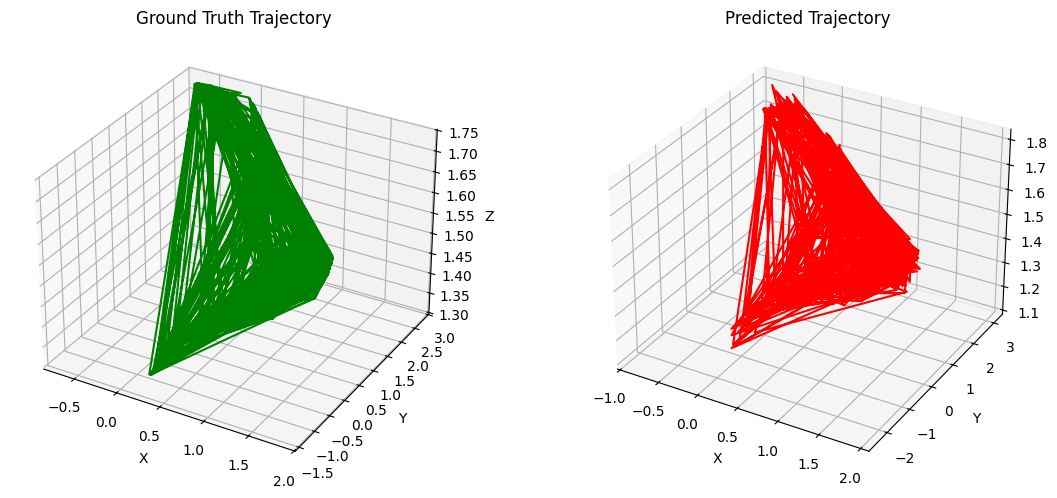

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Evaluate model
preds, gts = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        rgb = batch['rgb'].to(device)
        gt = batch['pose'].cpu().numpy()
        pred = model(rgb).cpu().numpy()

        preds.append(pred[:, :3])
        gts.append(gt[:, :3])

preds = np.concatenate(preds)
gts = np.concatenate(gts)

# Plot
fig = plt.figure(figsize=(12, 5))

# Ground Truth Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(gts[:, 0], gts[:, 1], gts[:, 2], c='green')
ax1.set_title("Ground Truth Trajectory")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# Predicted Plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(preds[:, 0], preds[:, 1], preds[:, 2], c='red')
ax2.set_title("Predicted Trajectory")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

plt.tight_layout()
plt.show()


In [10]:
# Save the model parameters (recommended)
torch.save(model.state_dict(), "posenet_rgbd.pth")
